<a target="_blank" href="https://colab.research.google.com/github/browndw/humanities_analytics/blob/main/mini_labs/Mini_Lab_03_Frequencies.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Mini Lab 3: Frequencies and Dispersions

To carry out this mini lab, we're going to install a couple of libraries. The first, is one that helps you process data using a specially trainined spaCy model that tags for both parts-of-speech and for rhetorical categories.

Its tagging scheme is based on the DocuScope dictionary developed by David Kaufer and Suguru Ishizaki. We'll be using this library for many of these labs.

For details about the package and it's functions see: <https://docuscospacy.readthedocs.io/en/latest/docuscope.html>

If you'd like to explore what this library does in an interactive online interface, you can go to: <https://docuscope-ca.eberly.cmu.edu/>

We'll also be using [great_tables](https://posit-dev.github.io/great-tables/articles/intro.html) to design and output tablular data.

## Install the

Note that the capture decorator simply supresses the installation output.

In [1]:
%%capture
!pip install docuscospacy>=0.3
!pip install great_tables

## Install the model

Next we'll install the model.

In [2]:
%%capture
!pip install "en_docusco_spacy @ https://huggingface.co/browndw/en_docusco_spacy/resolve/main/en_docusco_spacy-1.5-py3-none-any.whl"

## Load the libraries

We'll need these for our proceessing pipeline (docuscospacy, spacy) wrangle data frames (polars), generate and maipulate tables (great_tables) and create plots (matplotlib).

In [3]:
import docuscospacy as ds
import polars as pl
import spacy
from great_tables import GT, md, html
from matplotlib import pyplot as plt

## Import data

For this exercise, we'll import some toy data that was designed to replicate COCA on a small scale.

In [4]:
df = pl.read_parquet("https://github.com/browndw/humanities_analytics/raw/refs/heads/main/data/data_tables/sample_corpus.parquet")

Now we can check the data that we've imported. Note that the table has a `doc_id` column and a `text` column. This is conventional formatting for processing textual data. Also, note that we can encode meta-data into our file names. This is a crucial design step in building or organizing corpora.

Typically, **do not** use spaces in the file names. And use separators (like underscores, @ symbols, and hyphens) to delineate categories from other information. Here the underscore separates the text-type from an id number.

In [5]:
df.head()

doc_id,text
str,str
"""acad_01""","""Teachers and other school pers…"
"""acad_02""","""Abstract Does the conflict in …"
"""acad_03""","""January 17, 1993, will mark th…"
"""acad_04""","""Thirty years have passed since…"
"""acad_05""","""ABSTRACT -- A common property …"


## Load the model

As with any processing task of this kind, we will first need to load a model instance.

In [6]:
nlp = spacy.load("en_docusco_spacy")

## Process the corpus

Now, we pass our data frame `df` to the nlp model that we just loaded using the `docuscope_parse` function. This is the most computationally intensive part of the process (and it takes the longest). For this sample corpus, processing should take a couple of minutes.

If you're working with a medium to large corpus, you'd typically want to down-sample the full corpus and check to make everything is working before processing the full data set.

Down-sample our `df` would be easy using the `sample` function in [`polars`](https://docs.pola.rs/api/python/stable/reference/dataframe/api/polars.DataFrame.sample.html).

In [7]:
ds_tokens = ds.docuscope_parse(df, nlp_model=nlp, n_process=4)

Performance: Corpus processing completed in 29.68s


### Peek at the tokens

Now we can check what we've generated.

In [8]:
ds_tokens.head()

doc_id,token,pos_tag,ds_tag,pos_id,ds_id
str,str,str,str,u32,u32
"""acad_01""","""Teachers ""","""NN2""","""Character""",1,1
"""acad_01""","""and ""","""CC""","""Untagged""",2,2
"""acad_01""","""other ""","""JJ""","""InformationTopics""",3,3
"""acad_01""","""school ""","""NN1""","""InformationTopics""",4,3
"""acad_01""","""personnel ""","""NN2""","""Character""",5,4


## Creating a frequency table

Once we've tokenized our corpus, we can now create a table of token frequencies.

In [9]:
wc = ds.frequency_table(ds_tokens)

The default of the `frequency_table` is to count by parts-of-speech. However, we could just add `frequency_table(ds_tokens, count_by='ds')` to count by DocuScope tags instead.

In [10]:
wc.head()

Token,Tag,AF,RF,Range
str,str,u32,f64,f64
"""the""","""AT""",51032,49493.494717,100.0
"""and""","""CC""",25285,24522.711513,100.0
"""of""","""IO""",22524,21844.949737,100.0
"""a""","""AT1""",21998,21334.807509,100.0
"""to""","""TO""",16514,16016.13834,100.0


### Document-feature matrices

Another very common data structure that you should get to know is a "document-feature matrix" or a "document-term matrix". In these stuctures, each row is an observation (or text) and each column is a variable (or the thing we're counting).

In [11]:
dfm = ds.tags_dtm(ds_tokens)

And see what it looks like:

In [ ]:
dfm.head()

doc_id,NN1,JJ,II,AT,NN2,NP1,RR,CC,VVI,AT1,IO,VV0,VVD,MC,VVN,VVG,TO,VBZ,APPGE,PPIS1,VM,PPH1,PPY,DD1,PPHS1,XX,CS,VVZ,CST,RP,IF,VBDZ,IW,VBR,NNT1,GE,…,NNL1,NPD1,NNU2,CSW,MCMC,PPX2,DB2,VDN,VHG,MC2,FU,JK,FW,REX,PN,NP2,VHN,DDQGE,DDQV,PPGE,NNO2,VMK,NNU1,NNO,PNQO,BCL,RRT,MF,RPK,RRQV,VB0,RGQV,PNQV,NNA,NNL2,NP,NPD2
str,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
"""acad_01""",453,278,229,182,293,33,63,112,49,52,109,37,5,34,51,39,39,42,7,2,29,8,0,24,0,13,14,16,21,1,43,8,16,38,5,3,…,0,0,0,0,0,0,1,0,0,0,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
"""acad_02""",448,260,215,279,142,138,64,83,37,59,95,13,52,14,77,34,35,13,9,0,17,31,0,14,0,6,22,13,20,5,16,28,12,3,7,23,…,0,0,0,3,0,2,1,1,1,5,0,2,2,1,0,3,0,2,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
"""acad_03""",425,182,171,234,149,147,64,83,55,53,134,13,47,43,81,27,51,11,44,9,10,10,0,23,12,16,14,23,31,3,17,38,18,5,5,20,…,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,2,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
"""acad_04""",473,272,166,206,187,65,70,81,40,53,119,12,56,57,86,30,38,5,7,5,20,21,0,11,1,10,25,3,21,5,21,48,17,1,14,8,…,0,0,1,1,0,0,4,0,1,9,1,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""acad_05""",450,201,184,180,218,80,82,74,44,65,95,20,31,65,79,35,33,25,5,0,46,6,0,23,0,15,35,23,19,9,19,26,19,13,7,6,…,2,0,4,1,0,0,1,0,0,0,0,3,1,3,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


From that matrix (or table) we can create a summary table of our corpus data.

In [ ]:
totals = (dfm
          .with_columns(
              pl.sum_horizontal(pl.exclude("doc_id").alias("total"))
              ) # get the total words of each document by summing each row
          .select("doc_id", "total") # select the columns we want
          .with_columns(
              pl.col("doc_id").str.extract(r"^([a-z]+)", 1).alias("text_type")
          ) # extract the text-type from the doc_id
          ).group_by("text_type").agg(pl.col("total").sum()).sort("text_type") # aggregate using text_type as a group

Peek at the result:

In [ ]:
totals.head()

text_type,total
str,u32
"""acad""",125095
"""blog""",127443
"""fic""",129240
"""mag""",128869
"""news""",127402


### Using `great_tables`

Now it is simple to make a table for output.

In [ ]:
gt_tbl = GT(totals)

In [ ]:
gt_tbl

text_type,total
acad,125095
blog,127443
fic,129240
mag,128869
news,127402
spok,128702
tvm,128974
web,126769


Not only can that table be [manipulated and designed in myriad ways](https://posit-dev.github.io/great-tables/examples/), but it can be directly ouput in various formats.

In [ ]:
gt_tbl.as_latex()

'\\begin{table}[!t]\n\n\n\\fontsize{12.0pt}{14.4pt}\\selectfont\n\n\\begin{tabular*}{\\linewidth}{@{\\extracolsep{\\fill}}lr}\n\\toprule\ntext\\_type & total \\\\ \n\\midrule\\addlinespace[2.5pt]\nacad & 125095 \\\\\nblog & 127443 \\\\\nfic & 129240 \\\\\nmag & 128869 \\\\\nnews & 127402 \\\\\nspok & 128702 \\\\\ntvm & 128974 \\\\\nweb & 126769 \\\\\n\\bottomrule\n\\end{tabular*}\n\n\\end{table}\n'

## Some properties of token frequencies

Now let's go back to our frequency table.

In [ ]:
wc.head()

Token,Tag,AF,RF,Range
str,str,u32,f64,f64
"""the""","""AT""",51030,49907.38332,99.75
"""and""","""CC""",25288,24731.685467,99.5
"""of""","""IO""",22492,21997.195094,99.75
"""a""","""AT1""",22033,21548.292704,99.25
"""to""","""TO""",16269,15911.095811,99.0


Just glacing at the top of the table, a couple of things are obvious. The first is that on their own, frequencies aren't obviously interpretable. The most frequent words in most English language corpora will look much like this one.

Another issue is a property of word (or token) frequencies called [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law). To get a sense of what it is and it's implications let's create a simple plot.

We'll add a row index, which we'll call `rank` and take the first 250 rows.

In [15]:
plot_df = wc.with_row_index("rank", offset=1).head(250)

And we can use `matplotlib` to create a simple scatter plot of rank vs. absolute frequency.

Text(0.5, 1.0, "Zipf's Law")

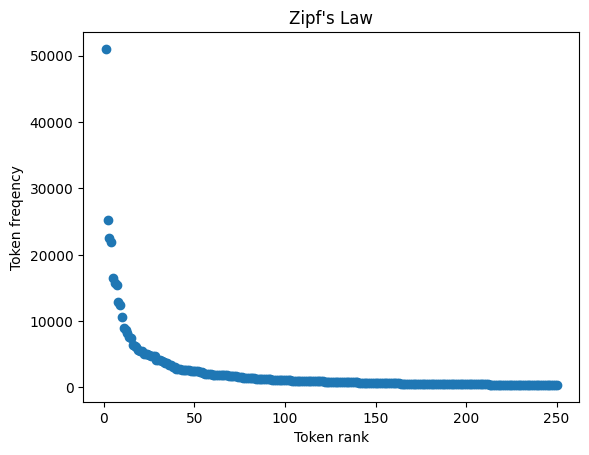

In [16]:
x = plot_df.select("rank").to_numpy()
y = plot_df.select("AF").to_numpy()

plt.scatter(x, y)

# Add labels and title
plt.xlabel('Token rank')
plt.ylabel('Token freqency')
plt.title("Zipf's Law")

#### Question 🤔

What does this mean for language processing and the inpretation of results?

## Dispersions

One fundamental question we might have in looking at a frequency of words (or tokens) is what is driving a frequency of a given token.

For example, let's say we find that *racoon* is particulary frequent in our data. Does that mean that we have a particularly racoon-y set of texts? Or is that say 1 or 2 texts that are just all about racoons?

For this reason, we might want to know how dispersed tokens are? One simply way to report this is to see what percentage of our texts that our token appears in.

The limiation to this approach is that our corpus may not contain texts of equal length. If some are shorter than others, the opportunity to a token to appear will not be equal.

This there are a variety of dispersion measure available. Some of these can be calculated using the `dispersions_table` function. For this, we simply pass our original tokens object to the function.


In [13]:
dt = ds.dispersions_table(ds_tokens)

Note that for some dispersion measures, the higher value means that the token is more dispersed.

In [14]:
dt.head()

Token,Tag,AF,RF,Carrolls_D2,…,Lynes_D3,DC,Juillands_D,DP,DP_norm
str,str,u64,f64,f64,…,f64,f64,f64,f64,f64
"""the""","""AT""",51032,49493.494717,0.988606,…,0.967496,0.962878,0.981737,0.143405,0.143702
"""and""","""CC""",25285,24522.711513,0.990274,…,0.973234,0.967056,0.983422,0.125533,0.125794
"""of""","""IO""",22524,21844.949737,0.979403,…,0.938009,0.9353,0.974667,0.197503,0.197913
"""a""","""AT1""",21998,21334.807509,0.992072,…,0.978803,0.97165,0.985503,0.111006,0.111236
"""to""","""TO""",16514,16016.13834,0.989978,…,0.973467,0.963931,0.983837,0.122953,0.123208


While for others, the **lower** the value, the **more** dispersed the token is.

In [ ]:
dt.tail()

Token,Tag,AF,RF,Carrolls_D2,Rosengrens_S,Lynes_D3,DC,Juillands_D,DP,DP_norm
str,str,u64,f64,f64,f64,f64,f64,f64,f64,f64
"""ramsey""","""NP1""",1,0.978001,0.0,0.002512,-98.75,0.0025,-2.2204e-16,0.997488,0.999571
"""polynesia""","""NP1""",1,0.978001,0.0,0.002512,-98.75,0.0025,-2.2204e-16,0.997488,0.999571
"""pb2y""","""FO""",1,0.978001,0.0,0.002512,-98.75,0.0025,-2.2204e-16,0.997488,0.999571
"""pt""","""NN1""",1,0.978001,0.0,0.002512,-98.75,0.0025,-2.2204e-16,0.997488,0.999571
"""sox""","""NN1""",1,0.978001,0.0,0.002512,-98.75,0.0025,-2.2204e-16,0.997488,0.999571


---

## 💭 Discussion Questions

1. **Zipf's Law and Interpretation**: Looking at the Zipf's Law visualization, what challenges does this distribution create for interpreting frequency data? How might you adjust your analysis methods to account for this?

2. **Dispersion vs. Frequency**: Why might a high-frequency token with low dispersion be less interesting than a medium-frequency token with high dispersion? Think of concrete examples from your own research area.

3. **Token Granularity**: We can analyze frequencies at different levels (characters, tokens, tags, n-grams). What are the tradeoffs of each approach? When might you choose one over another?

4. **Document-Feature Matrices**: The DFM converts text into a numerical representation. What information is preserved in this transformation? What information is lost? How does this affect downstream analysis?

5. **Frequency Tables Across Corpora**: If you compared frequency tables from two different text types (e.g., academic vs. fiction), what patterns would you expect? What might surprise you?

6. **Critical Reflection**: Frequency-based methods assume that "importance" correlates with frequency. Can you think of cases where this assumption breaks down? What alternatives exist?

## 🔬 Experimentation Ideas

Try modifying the code above to explore these questions:

1. **Filter by POS tags**: Create a frequency table that only includes nouns (NN1, NN2). How does this change the distribution?

2. **Compare text types**: Split the frequency table by the `text_type` variable (academic vs. fiction) and compare the top 20 tokens in each. What patterns emerge?

3. **N-gram analysis**: Use the `ngrams_table()` function (see docuscospacy documentation) to analyze 2-grams or 3-grams instead of single tokens. What new insights appear?

4. **Custom dispersion thresholds**: Filter your frequency table to only show tokens that appear in at least 50% of documents. How does this change your results?

5. **Visualize dispersion**: Create a scatter plot of frequency (x-axis) vs. dispersion (y-axis) for the top 500 tokens. What clusters or patterns emerge?

6. **Rhetorical category frequencies**: Instead of individual tokens, create a frequency table for `ds_tag` (DocuScope categories). What are the most common rhetorical moves in your corpus?